In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import random
from tensorboardX import SummaryWriter
torch.manual_seed(1)

USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### CIFAR-10

In [2]:
train_dataset = vdatasets.CIFAR10(root='../data/CIFAR10/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.CIFAR10(root='../data/CIFAR10/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_dataset[0][0].size())

torch.Size([3, 32, 32])


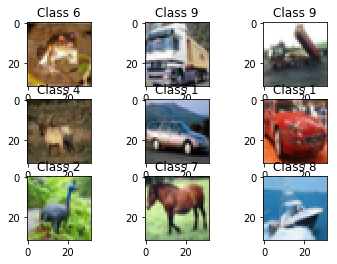

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].transpose(0,1).transpose(1,2).numpy(),interpolation=None)
    plt.title("Class {}".format(train_dataset[i][1]))

In [123]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3,64,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
            )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64,128,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*8*8,256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
    
        self.deconv = nn.ConvTranspose2d(1,3,5,padding=2)
        self.unpooling = nn.MaxUnpool2d(2)

    
    def visualize_layer(self,inputs,layer=None):
        inputs,indices1 = self.conv_layer1(inputs)
        
        featuremaps=[]
#         index = random.choice(range(inputs.size(1)))
        for index in range(inputs.size(1)):
            featuremap = inputs[0][index].view(1,1,inputs.size(2),inputs.size(3))
            f_indices = indices1[0][index].view(1,1,inputs.size(2),inputs.size(3))
            unpooled = self.unpooling(featuremap,f_indices)
            unpooled = F.relu(unpooled)

            # 해당 필터 weight 복사
            self.deconv.weight.data = self.conv_layer1[0].weight.data[index].unsqueeze(0).clone()
            deconved1 = self.deconv(unpooled)
            featuremaps.append(deconved1)
        return featuremaps
        
    def forward(self,inputs):
        inputs,_ = self.conv_layer1(inputs)
        inputs,_ = self.conv_layer2(inputs)
        
        return self.fc(inputs.view(inputs.size(0),-1))
        

In [143]:
EPOCH=10
LR=0.001
BATCH_SIZE=64

model = CNN()
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [144]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        if USE_CUDA:
            inputs,targets = inputs.cuda(),targets.cuda()
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 300 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/10] [000/782] mean_loss : 2.306
[0/10] [300/782] mean_loss : 1.681
[0/10] [600/782] mean_loss : 1.340
[1/10] [000/782] mean_loss : 1.005
[1/10] [300/782] mean_loss : 1.105
[1/10] [600/782] mean_loss : 1.052
[2/10] [000/782] mean_loss : 0.894
[2/10] [300/782] mean_loss : 0.909
[2/10] [600/782] mean_loss : 0.888
[3/10] [000/782] mean_loss : 0.582
[3/10] [300/782] mean_loss : 0.775
[3/10] [600/782] mean_loss : 0.789
[4/10] [000/782] mean_loss : 0.638
[4/10] [300/782] mean_loss : 0.678
[4/10] [600/782] mean_loss : 0.700
[5/10] [000/782] mean_loss : 0.870
[5/10] [300/782] mean_loss : 0.586
[5/10] [600/782] mean_loss : 0.608
[6/10] [000/782] mean_loss : 0.606
[6/10] [300/782] mean_loss : 0.500
[6/10] [600/782] mean_loss : 0.527
[7/10] [000/782] mean_loss : 0.348
[7/10] [300/782] mean_loss : 0.411
[7/10] [600/782] mean_loss : 0.467
[8/10] [000/782] mean_loss : 0.295
[8/10] [300/782] mean_loss : 0.354
[8/10] [600/782] mean_loss : 0.395
[9/10] [000/782] mean_loss : 0.295
[9/10] [300/782] mea

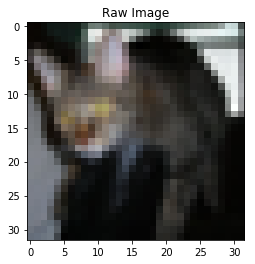

Featuremaps from layer1


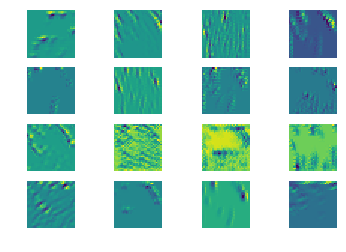

In [179]:
model = model.cpu()
input = random.choice(test_dataset)[0]

plt.imshow(input.transpose(0,1).transpose(1,2).numpy(), interpolation='none')
plt.title("Raw Image")
plt.show()

features = model.visualize_layer(Variable(input.unsqueeze(0)))

print("Featuremaps from layer1")
for i,feature in enumerate(features[:16]):
    plt.subplot(4,4,i+1)
    plt.axis("off")
    plt.imshow(feature.squeeze().transpose(0,1).transpose(1,2).data.numpy()[:,:,0],interpolation='none')
#     plt.show()